### Title: Correlation Analysis performed by Joy Jayesh Patel
### Author: Joy Patel

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Tested on simple.csv, complex.csv and Time Series(Simple Data Relation.csv)

In [3]:
data = pd.read_csv("complex_iot.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    1008 non-null   int64  
 1   s1      1008 non-null   float64
 2   s2      1008 non-null   float64
 3   s3      1008 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 31.6 KB


In [5]:
data.columns = data.columns.str.strip()

In [6]:
# Ask user to select columns that contain sensor data ( in the project, these values will be fetched from the front-end )
print("Available columns:", data.columns.tolist())
sensor_columns = input("Enter sensor column names that contain sensor data for further processing(separated by comma) : ").split(',')

# The entered columns are then stripped for whitespaces
sensor_columns = [col.strip() for col in sensor_columns]

#New dataframe is created with only the sensor data stream columns
sensor_columns_data = data[sensor_columns]


Available columns: ['time', 's1', 's2', 's3']


Enter sensor column names that contain sensor data for further processing(separated by comma) :  s1,s2,s3


In [7]:
sensor_columns

['s1', 's2', 's3']

In [8]:
#Filling the null values in sensor data columns with the median
for column in sensor_columns:
    sensor_columns_data.loc[:,column] = sensor_columns_data[column].fillna(sensor_columns_data[column].median())

In [9]:
#Cross checkinf null-values
sensor_columns_data.isnull().sum()

s1    0
s2    0
s3    0
dtype: int64

In [10]:
len(data)

1008

In [11]:
window_size = int(input("Enter window size: "))

Enter window size:  15


In [12]:
# sensor_columns is a list containing column names that contain stream data
# sensor_columns_data is a dataframe containing the data for the above columns

In [13]:
sensor_columns_data

,s1,s2,s3
0,1.000000,2.000000,0.700000
1,1.010000,1.999950,0.707000
2,1.019999,1.999800,0.713999
3,1.029996,1.999550,0.720997
4,1.039989,1.999200,0.727993
...,...,...,...
1003,0.431055,0.177624,0.301739
1004,0.422860,0.183355,0.296002
1005,0.414723,0.189167,0.290306
1006,0.406644,0.195060,0.284651


In [14]:
# Creating a dictionary to store the pairwise correlations where keys are the names of the 2 columns and the value will the corr values
correlations = {}

# Calculates correlation for all windows for 2 columns at a time
for i in range(len(sensor_columns)):
    for j in range(i + 1, len(sensor_columns)):
        pair = f"{sensor_columns[i]}_{sensor_columns[j]}"
        corrs = [] # list that stores the correlation values for 2 specific sensor stream columns
        start_index=[] # list that stores the start index
        end_index=[] # list that stores the end index
        
        for start in range(len(data) - window_size + 1):
            end=start + window_size
            window = data.iloc[start:end]                                            # extracts the data for the current window
            corr = window[sensor_columns[i]].corr(window[sensor_columns[j]])         # calculates the correlation value for the selected window
            corrs.append(corr)                          # appends the corr value to the list
            start_index.append(start)                   # adds start index
            end_index.append(end-1)                     # adds end index
        correlations[pair] = corrs                   # adds correlation values for all windows of the 2 columns as a key:value pair. The key is the joint column name
        correlations["start_index"]=start_index      # adds start index ( will add it multiple times )
        correlations["end_index"]=end_index          # same as above

In [15]:
# Converting the correlations dictionary into Dataframe

In [16]:
corr_df = pd.DataFrame(correlations)

In [17]:
# Sorting the columns in sliding window correlation dataframe

In [18]:
def sort_columns(corr_df):
    index_cols = [col for col in corr_df.columns if 'index' in col]
    other_cols = [col for col in corr_df.columns if col not in index_cols]
    corr_df = corr_df[index_cols + other_cols]
    return corr_df

In [19]:
corr_df = sort_columns(corr_df)

In [20]:
#corr_df.to_csv("correlation_for_ocsvm.csv",index=False)

In [21]:
corr_df.describe()

,start_index,end_index,s1_s2,s1_s3,s2_s3
count,994.000000,994.000000,994.000000,994.000000,994.000000
mean,496.500000,510.500000,0.102331,0.838909,-0.051572
std,287.087385,287.087385,0.973697,0.528522,0.980511
min,0.000000,14.000000,-0.999263,-0.999235,-0.999263
25%,248.250000,262.250000,-0.998036,1.000000,-0.998573
50%,496.500000,510.500000,0.960327,1.000000,-0.913491
75%,744.750000,758.750000,0.998957,1.000000,0.998389
max,993.000000,1007.000000,1.000000,1.000000,0.999263


In [22]:
# In s1 and s3, the correlation falters at 300 and improves from 391 onwards

In [23]:
threshold = float(input("Enter threshold value: "))

Enter threshold value:  0.8


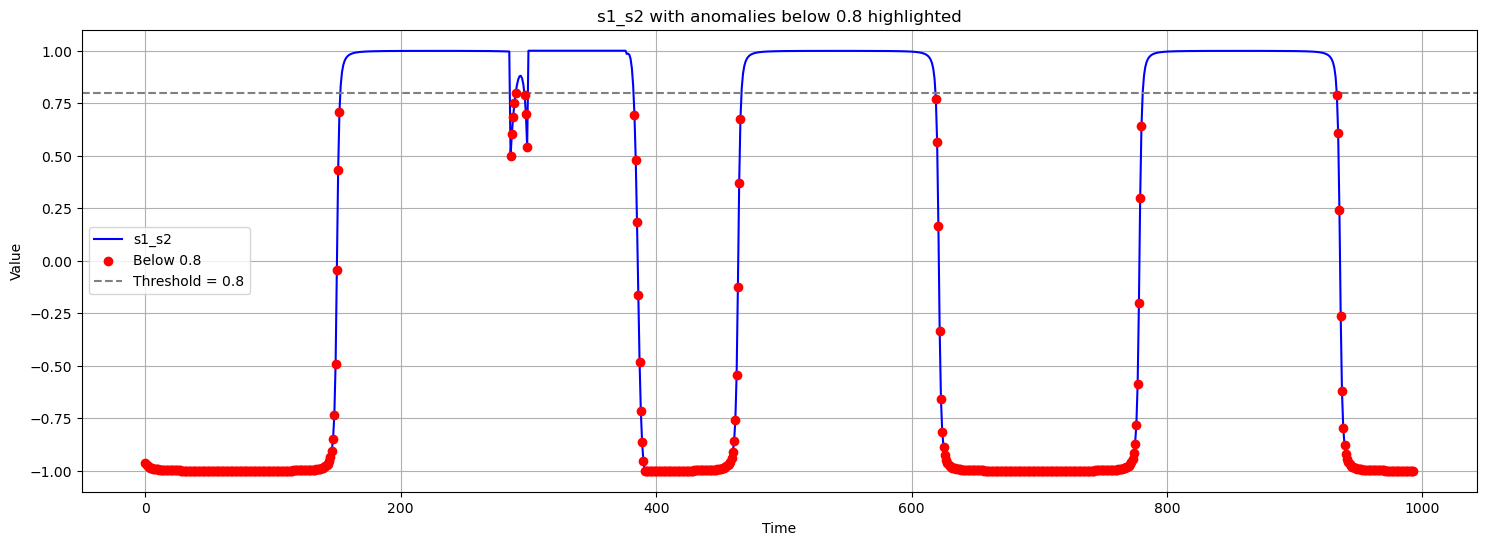

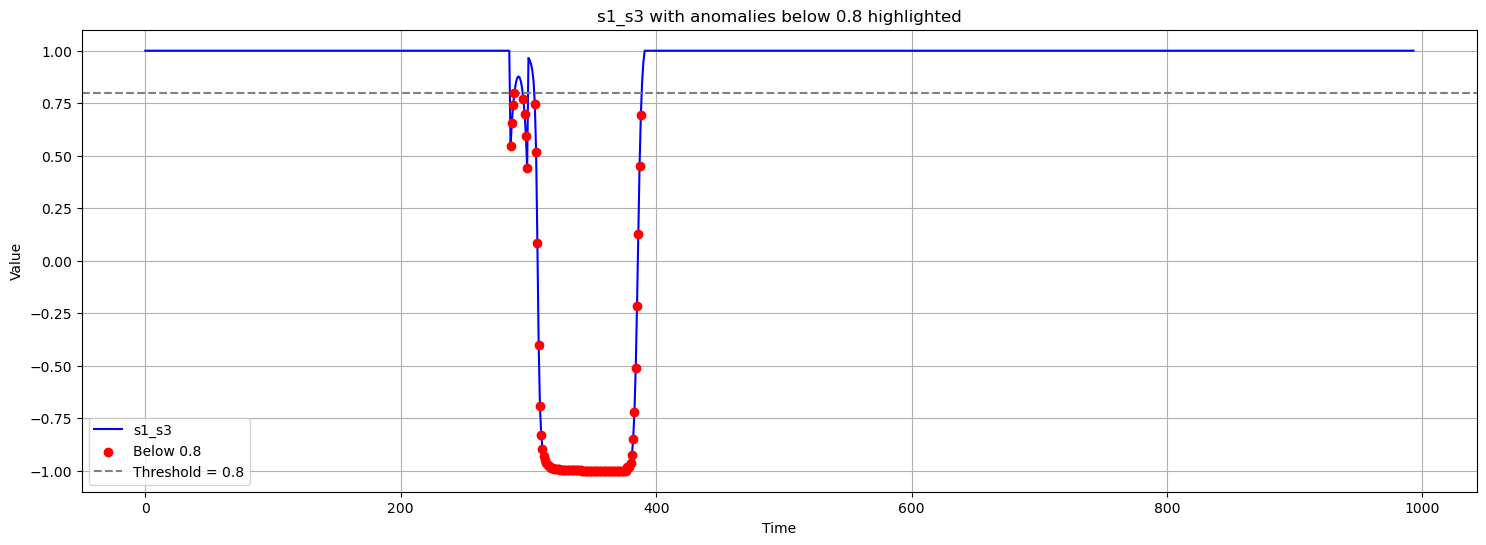

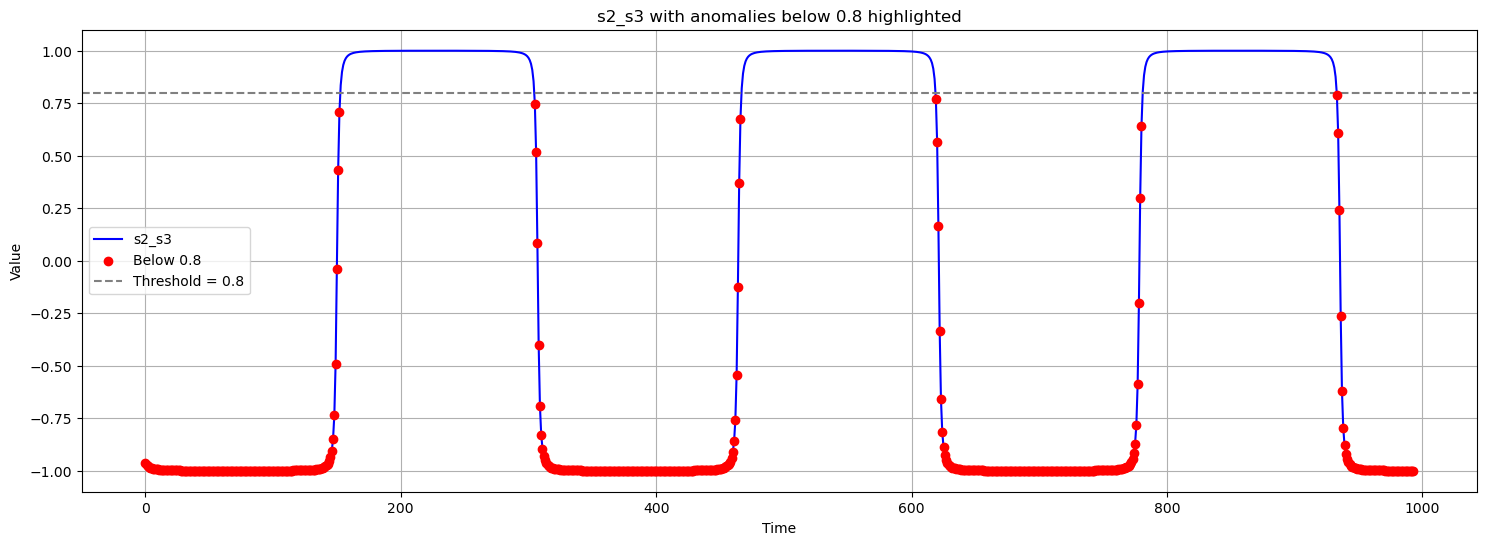

In [24]:
# Plotting anomalies using correlation and expected threshold

import matplotlib.pyplot as plt

for i in range(2,len(corr_df.columns)):
    sensor = corr_df.columns[i]
    x = corr_df['start_index']
    y = corr_df[sensor]

    # Plot the full line
    plt.figure(figsize=(18, 6))
    plt.plot(y, label=sensor, color='blue')
    
    # Highlight points below threshold
    below_thresh = y < threshold
    plt.scatter(x[below_thresh],y[below_thresh], color='red', label=f'Below {threshold}', zorder=5)
    
    # Optional formatting
    plt.axhline(threshold, color='gray', linestyle='--', label=f'Threshold = {threshold}')
    plt.title(f"{sensor} with anomalies below {threshold} highlighted")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()